# 1. 加载数据
加载训练集数据，并输出数据集大小

In [89]:
import numpy as np

# 加载训练集数据
X_train = np.load('../data_set/X_train.npy')

X_train  # 输出训练集数据

array([[57.,  5.,  0., ...,  0.,  0.,  0.],
       [71.,  2.,  2., ...,  0.,  0.,  1.],
       [64.,  2.,  0., ...,  0.,  0.,  0.],
       ...,
       [46.,  4.,  0., ...,  1.,  0.,  0.],
       [70.,  2.,  1., ...,  0.,  0.,  0.],
       [60.,  2.,  0., ...,  0.,  0.,  0.]])

In [90]:
X_train.shape  # 输出训练集大小

(1000, 111)

# 2. 清理数据
清理去除以下特征：
- 缺失率高于阈值(90%)的特征
- 一元特征
重新输出清理后的数据集大小

In [91]:
# 计算每个特征的缺失值比例
missing_ratio = np.mean(np.isnan(X_train), axis=0)

missing_ratio


array([0.005, 0.   , 0.002, 0.067, 0.046, 0.034, 0.963, 0.005, 0.004,
       0.153, 0.034, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016, 0.016,
       0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.012, 0.002, 0.002,
       0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.644, 0.644, 0.161,
       0.161, 0.007, 0.008, 0.009, 0.007, 0.007, 0.007, 0.051, 0.05 ,
       0.048, 0.043, 0.   , 0.096, 0.096, 0.096, 0.096, 0.096, 0.096,
       0.069, 0.069, 0.069, 0.069, 0.069, 0.069, 0.069, 0.069, 0.069,
       0.068, 0.068, 0.068, 0.068, 0.068, 0.068, 0.068, 0.068, 0.068,
       0.068, 0.068, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006,
       0.201, 0.201, 0.204, 0.204, 0.174, 0.175, 0.998, 0.074, 0.115,
       0.08 , 0.009, 0.069, 0.08 , 0.371, 0.392, 0.382, 0.003, 0.003,
       0.068, 0.082, 0.007, 0.069, 0.081, 0.005, 0.004, 0.005, 0.008,
       0.008, 0.007, 0.007])

In [92]:
# 定义高缺失率阈值为90%
high_missing_ratio_threshold = 0.9

# 标记应删除的特征
features_to_drop_high_missing = np.where(missing_ratio > high_missing_ratio_threshold)[0]

# 计算每个特征的唯一值数量
unique_counts = np.apply_along_axis(lambda col: len(np.unique(col[~np.isnan(col)])), 0, X_train)

# 一元特征的索引
single_value_feature_indices = np.where(unique_counts == 1)[0]

# 删除高缺失率特征和一元特征
X_dropped_high_missing = np.delete(X_train,
                                   np.concatenate([features_to_drop_high_missing, single_value_feature_indices]),
                                   axis=1)

# 保存删除高缺失率特征和一元特征后的数据
np.save('../data_set/processed_data_set/X_drop.npy', X_dropped_high_missing)

# 输出删除高缺失率特征和一元特征后的数据集大小
features_to_drop_high_missing, single_value_feature_indices, X_dropped_high_missing.shape

(array([ 6, 87], dtype=int64),
 array([ 6, 12, 16, 18, 21, 23, 31, 51, 61, 66, 77, 80], dtype=int64),
 (1000, 98))

# 3. 特征类型分类
对特征进行分类，离散型和连续型

In [93]:
# 加载删除高缺失率特征后的数据
X_train = np.load('../data_set/processed_data_set/X_drop.npy')

# 确定每个特征的唯一值数量
unique_counts = np.apply_along_axis(lambda col: len(np.unique(col[~np.isnan(col)])), 0, X_dropped_high_missing)

# 使用唯一值数量与样本总数的比例来推断特征类型
# 设定一个阈值
# 如果唯一值占总样本数的比例小于5%是离散型特征，否则是连续型特征
threshold_ratio = 0.05
discrete_feature_indices = np.where((unique_counts / X_train.shape[0]) < threshold_ratio)[0]
continuous_feature_indices = np.where((unique_counts / X_train.shape[0]) >= threshold_ratio)[0]

discrete_feature_indices, continuous_feature_indices  # 输出离散型和连续型特征的索引


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 72,
        78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
        95, 96, 97], dtype=int64),
 array([ 0, 27, 28, 29, 71, 73, 74, 75, 76, 77], dtype=int64))

## 3.1 连续性特征分类为整数型和浮点型

In [94]:
# 初始化列表来保存整数型和浮点型连续特征的索引
continuous_integer_indices = []
continuous_float_indices = []

# 遍历所有连续型特征，检查它们是整数型还是浮点型
for index in continuous_feature_indices:
    if np.all(np.mod(X_train[:, index][~np.isnan(X_train[:, index])], 1) == 0):
        continuous_integer_indices.append(index)
    else:
        continuous_float_indices.append(index)

continuous_integer_indices, continuous_float_indices

([0, 27, 28, 29], [71, 73, 74, 75, 76, 77])

按照这个分类，我们将对缺失值采取不同的填充策略：

对于**离散型特征**，我们将使用众数进行填充。
对于**连续浮点型特征**，我们将使用均值进行填充。
对于**连续整数型特征**，我们也将使用均值进行填充，然后对结果进行四舍五入，以确保填充值保持为整数。

In [95]:
from sklearn.impute import SimpleImputer

# 对离散型特征使用众数填充
imputer_mode = SimpleImputer(strategy='most_frequent')
X_train[:, discrete_feature_indices] = imputer_mode.fit_transform(X_train[:, discrete_feature_indices])

# 对连续浮点型特征使用均值填充
imputer_mean = SimpleImputer(strategy='mean')
X_train[:, continuous_float_indices] = imputer_mean.fit_transform(X_train[:, continuous_float_indices])

# 对连续整数型特征使用均值填充并四舍五入
X_continuous_integer = imputer_mean.fit_transform(X_train[:, continuous_integer_indices])
X_train[:, continuous_integer_indices] = np.round(X_continuous_integer)

# 保存填充后的数据
np.save('../data_set/processed_data_set/X_filled.npy', X_train)

# 验证处理后的数据是否还含有缺失值
missing_after_imputation = np.isnan(X_train).sum()

missing_after_imputation


0

In [96]:
X_train  # 输出处理后的数据

array([[57.,  5.,  0., ...,  0.,  0.,  0.],
       [71.,  2.,  2., ...,  0.,  0.,  1.],
       [64.,  2.,  0., ...,  0.,  0.,  0.],
       ...,
       [46.,  4.,  0., ...,  1.,  0.,  0.],
       [70.,  2.,  1., ...,  0.,  0.,  0.],
       [60.,  2.,  0., ...,  0.,  0.,  0.]])

Feature index 27: 339 outliers detected


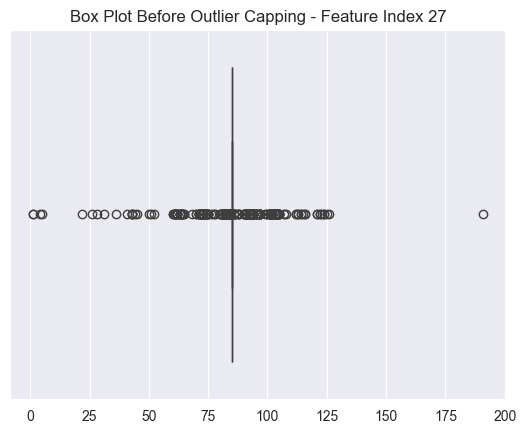

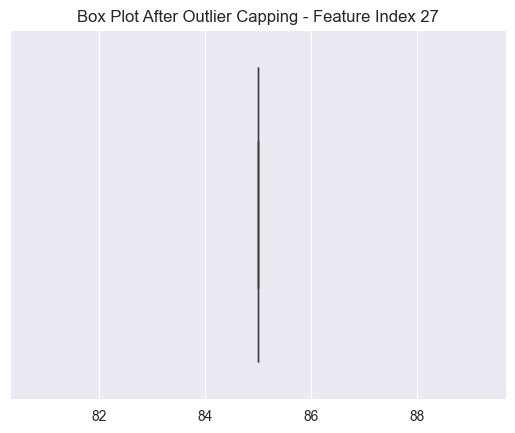

Feature index 28: 69 outliers detected


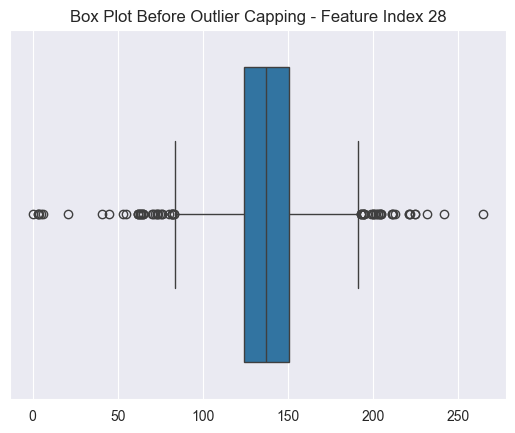

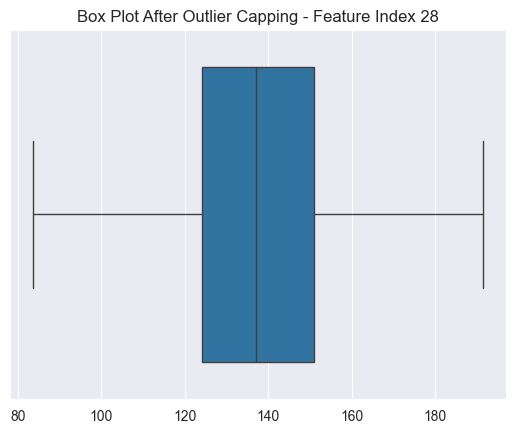

Feature index 29: 106 outliers detected


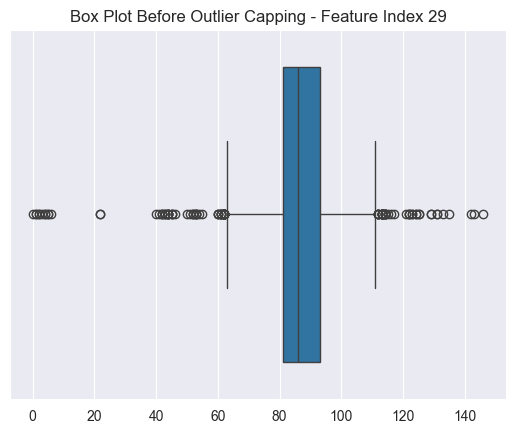

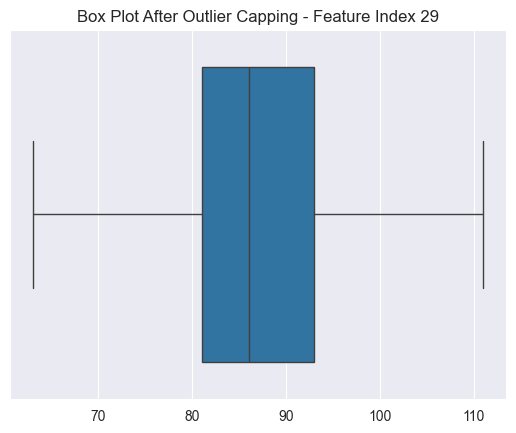

Feature index 71: 71 outliers detected


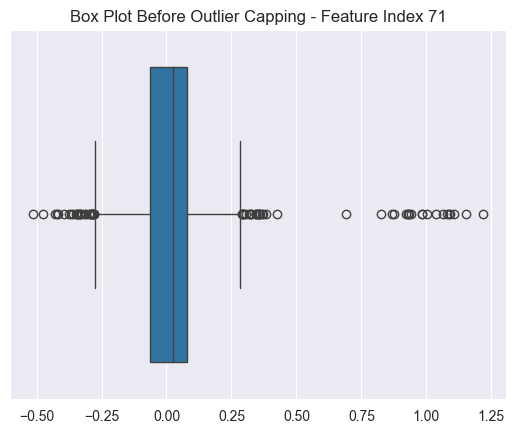

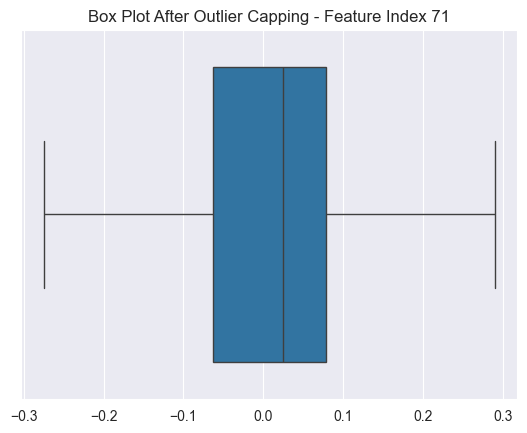

Feature index 73: 59 outliers detected


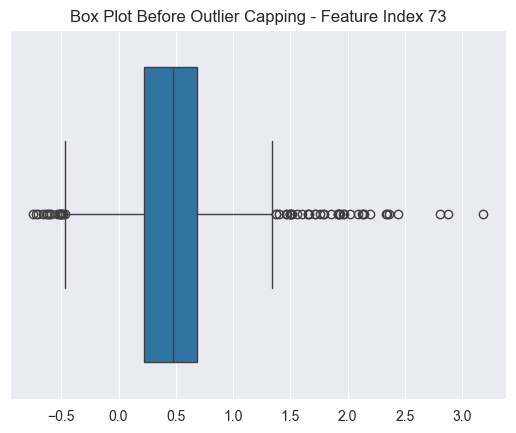

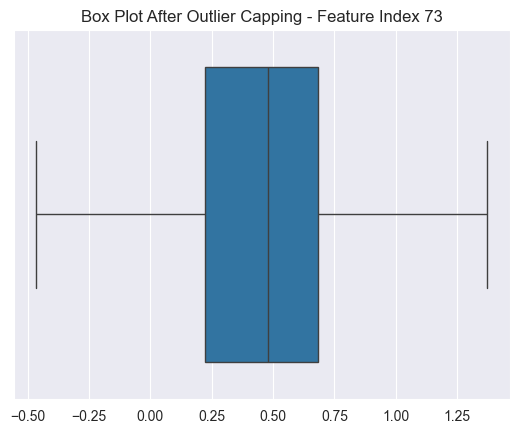

Feature index 74: 34 outliers detected


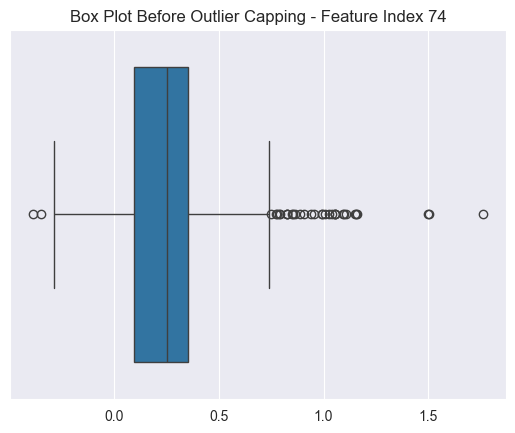

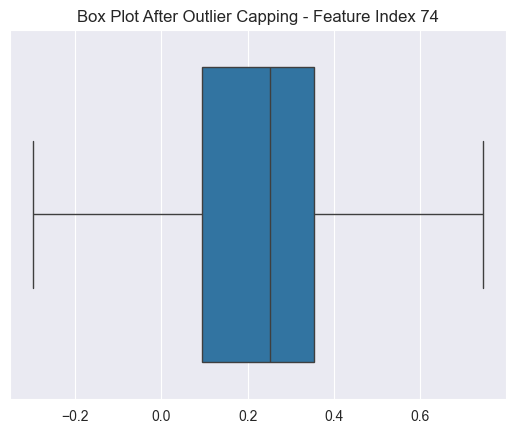

Feature index 75: 30 outliers detected


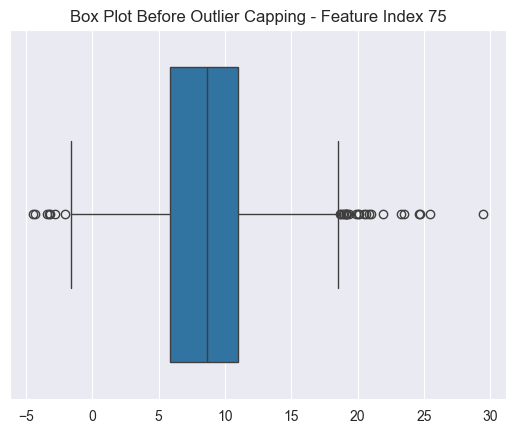

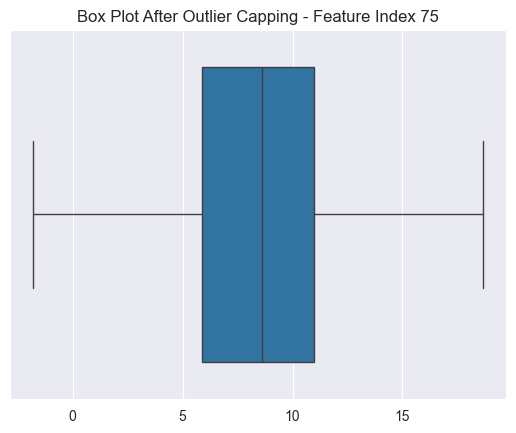

Feature index 76: 21 outliers detected


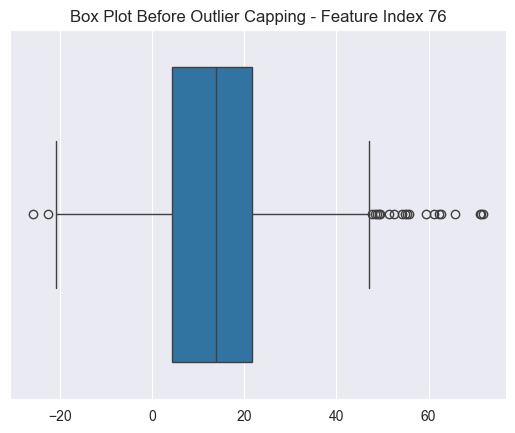

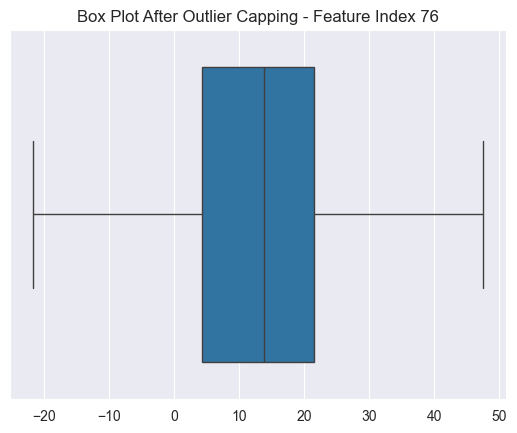

Feature index 77: 5 outliers detected


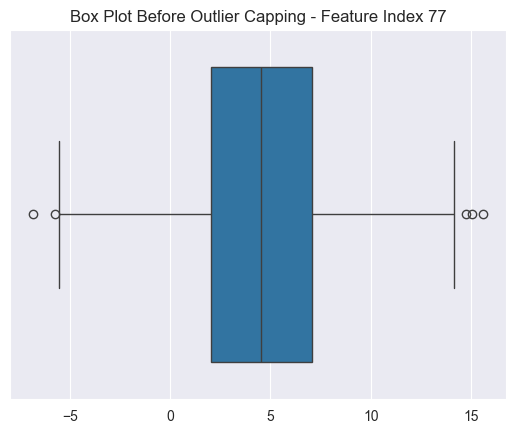

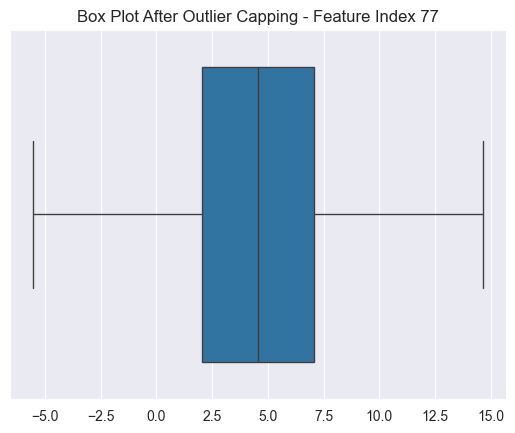

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

# 加载填充后的数据
X_cleaned = np.load('../data_set/processed_data_set/X_filled.npy')

# 定义处理离群值的函数
def cap_outliers(data, lower_bound, upper_bound):
    data = np.where(data < lower_bound, lower_bound, data)
    data = np.where(data > upper_bound, upper_bound, data)
    return data

# 遍历每个连续特征
for feature_index in continuous_feature_indices:  # 使用之前确定的连续特征索引列表
    feature_data = X_cleaned[:, feature_index]
    q1, q3 = np.percentile(feature_data[~np.isnan(feature_data)], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 检查是否有超出上下界的离群值
    outlier_indices = np.where((feature_data < lower_bound) | (feature_data > upper_bound))[0]
    if len(outlier_indices) > 0:
        print("Feature index {}: {} outliers detected".format(feature_index, len(outlier_indices)))

        # 可视化特征的箱线图（处理前）
        sns.boxplot(x=feature_data)
        plt.title('Box Plot Before Outlier Capping - Feature Index {}'.format(feature_index))
        plt.show()

        # 处理离群值
        X_cleaned[:, feature_index] = cap_outliers(feature_data, lower_bound, upper_bound)

        # 可视化特征的箱线图（处理后）
        sns.boxplot(x=X_cleaned[:, feature_index])
        plt.title('Box Plot After Outlier Capping - Feature Index {}'.format(feature_index))
        plt.show()

# 保存处理后的数据
np.save('../data_set/processed_data_set/X_processed.npy', X_cleaned)
